In [1]:
import mediapipe as mp
print(mp.__version__)


0.10.5


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import time
import random

class EfficientNetISLClassifier:
    def __init__(self, data_dir, num_classes=None, device=None):
        self.data_dir = data_dir
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Transforms
        self.train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        self.val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.setup_datasets()
        self.model = self.create_model()
        self.best_acc = 0.0
        self.class_names = self.train_dataset.classes
        
        print(f"EfficientNet-B0 initialized")
        print(f"Device: {self.device}")
        print(f"Number of classes: {len(self.class_names)}")
        print(f"Training samples: {len(self.train_dataset)}")
        print(f"Validation samples: {len(self.val_dataset)}")
    
    def setup_datasets(self):
        self.train_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, "train"), transform=self.train_transforms)
        
        self.val_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, "valid"), transform=self.val_transforms)
        
        test_path = os.path.join(self.data_dir, "test")
        if os.path.exists(test_path):
            self.test_dataset = datasets.ImageFolder(test_path, transform=self.val_transforms)
        else:
            self.test_dataset = None
        
        self.train_loader = DataLoader(self.train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
        if self.test_dataset:
            self.test_loader = DataLoader(self.test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

    def create_model(self):
        model = models.efficientnet_b3(pretrained=True)
        num_classes = len(self.train_dataset.classes)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
        return model.to(self.device)

    def train(self, num_epochs=50, learning_rate=0.001, save_path="best_efficientnet_model1.pth"):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        train_losses = []
        train_accuracies = []
        val_accuracies = []

        print(f" Starting training for {num_epochs} epochs...")
        print("=" * 60)

        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()
            train_running_loss = 0.0
            train_running_corrects = 0

            train_pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
            for inputs, labels in train_pbar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                train_running_corrects += torch.sum(preds == labels.data)

                train_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{train_running_corrects.double() / len(self.train_dataset):.4f}'
                })

            epoch_loss = train_running_loss / len(self.train_dataset)
            epoch_acc = train_running_corrects.double() / len(self.train_dataset)
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())

            self.model.eval()
            val_running_corrects = 0
            with torch.no_grad():
                val_pbar = tqdm(self.val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
                for inputs, labels in val_pbar:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    _, preds = torch.max(outputs, 1)
                    val_running_corrects += torch.sum(preds == labels.data)
                    val_pbar.set_postfix({
                        'Acc': f'{val_running_corrects.double() / len(self.val_dataset):.4f}'
                    })

            val_acc = val_running_corrects.double() / len(self.val_dataset)
            val_accuracies.append(val_acc.item())
            scheduler.step()

            print(f"Epoch {epoch+1}/{num_epochs} - Time: {time.time() - start_time:.2f}s")
            print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}")

            if val_acc > self.best_acc:
                self.best_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_acc': self.best_acc,
                    'class_names': self.class_names
                }, save_path)
                print(f"New best model saved! Accuracy: {val_acc:.4f}")
            print("-" * 60)

        print(f"Training completed! Best validation accuracy: {self.best_acc:.4f}")
        self.plot_training_history(train_losses, train_accuracies, val_accuracies)

        return {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
            'best_acc': self.best_acc.item()
        }

    def plot_training_history(self, train_losses, train_accuracies, val_accuracies):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(train_losses, label='Training Loss')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(train_accuracies, label='Training Accuracy')
        ax2.plot(val_accuracies, label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Training history plot saved as 'training_history.png'")

    def load_model(self, model_path):
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.best_acc = checkpoint['best_acc']
        self.class_names = checkpoint['class_names']
        print(f"Model loaded from {model_path}")
        print(f"Best accuracy: {self.best_acc:.4f}")

    def test_on_image(self, image_path, model_path=None):
        if model_path:
            self.load_model(model_path)

        image = Image.open(image_path).convert('RGB')
        input_tensor = self.val_transforms(image)
        input_batch = input_tensor.unsqueeze(0).to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(input_batch)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

        top_probs, top_indices = torch.topk(probabilities, 5)
        top_probs = top_probs.cpu().numpy()
        top_indices = top_indices.cpu().numpy()

        print(f"\nTesting image: {image_path}")
        print("="*50)
        for i in range(len(top_probs)):
            class_name = self.class_names[top_indices[i]]
            confidence = top_probs[i] * 100
            print(f"#{i+1}: {class_name} - {confidence:.2f}%")

        return {
            'predictions': [(self.class_names[idx], prob) for idx, prob in zip(top_indices, top_probs)],
            'top_class': self.class_names[top_indices[0]],
            'confidence': top_probs[0]
        }

    def evaluate_model(self, model_path=None, use_test_set=False):
        if model_path:
            self.load_model(model_path)

        if use_test_set and self.test_dataset:
            eval_loader = self.test_loader
            eval_dataset = self.test_dataset
            set_name = "Test"
        else:
            eval_loader = self.val_loader
            eval_dataset = self.val_dataset
            set_name = "Validation"

        print(f"Evaluating model on {set_name} set...")
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(eval_loader, desc="Evaluating"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
        print(f"\n {set_name} Set Accuracy: {accuracy:.4f}")
        print("\n Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=self.class_names))

        self.plot_confusion_matrix(all_labels, all_preds)
        return {'accuracy': accuracy, 'predictions': all_preds, 'labels': all_labels}

    def plot_confusion_matrix(self, labels, predictions):
        cm = confusion_matrix(labels, predictions)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Confusion matrix saved as 'confusion_matrix1.png'")


def main():
    data_dir = r"E:\New folder\isl_inverted"
    classifier = EfficientNetISLClassifier(data_dir)

    print("Starting training...")
    classifier.train(num_epochs=15, learning_rate=0.001, save_path="best_efficientnet_isl2_model.pth")

    print("\nEvaluating model...")
    classifier.evaluate_model("best_efficientnet_isl_model.pth")

    print("\nTesting on sample images...")
    val_samples = []
    for class_idx, class_name in enumerate(classifier.class_names):
        class_path = os.path.join(data_dir, "valid", class_name)
        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if images:
                val_samples.append(os.path.join(class_path, random.choice(images)))

    for i, image_path in enumerate(val_samples[:3]):
        print(f"\n--- Sample {i+1} ---")
        result = classifier.test_on_image(image_path, "best_efficientnet_isl_model.pth")
        print(f"Predicted: {result['top_class']} ({result['confidence']*100:.2f}%)")


if __name__ == "__main__":
    main()


e:\ANACONDA3\envs\cv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\ANACONDA3\envs\cv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet-B0 initialized
Device: cpu
Number of classes: 30
Training samples: 2380
Validation samples: 688
Starting training...
 Starting training for 15 epochs...


Epoch 1/15 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]e:\ANACONDA3\envs\cv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/15 [Train]:  11%|█         | 16/149 [01:05<09:01,  4.07s/it, Loss=3.2595, Acc=0.0139]


KeyboardInterrupt: 

In [4]:
import cv2
import torch
import mediapipe as mp
import numpy as np
from torchvision import models, transforms
from PIL import Image

# ✅ Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# ✅ Load EfficientNet-B0 model
model = models.efficientnet_b0(pretrained=False)
num_classes = 30
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

# Load weights
checkpoint = torch.load("best_efficientnet_isl_model.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

# ✅ Class names
class_names = checkpoint["class_names"]

# ✅ Define transform (same as during validation)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ MediaPipe hands setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# ✅ Predict function
def predict_hand(frame):
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        h, w, _ = frame.shape
        x_min, y_min, x_max, y_max = w, h, 0, 0

        for hand_landmarks in results.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                x_min = min(x, x_min)
                y_min = min(y, y_min)
                x_max = max(x, x_max)
                y_max = max(y, y_max)

        # Add padding
        pad = 30
        x_min = max(x_min - pad, 0)
        y_min = max(y_min - pad, 0)
        x_max = min(x_max + pad, w)
        y_max = min(y_max + pad, h)

        cropped_hand = frame[y_min:y_max, x_min:x_max]

        if cropped_hand.size == 0:
            return None, 0.0

        # Transform and predict
        pil_img = Image.fromarray(cv2.cvtColor(cropped_hand, cv2.COLOR_BGR2RGB))
        input_tensor = transform(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.nn.functional.softmax(outputs[0], dim=0)
            pred_index = torch.argmax(probs).item()
            confidence = probs[pred_index].item()

        return class_names[pred_index], confidence
    else:
        return None, 0.0

# ✅ Webcam
cap = cv2.VideoCapture(r"E:\New folder\WhatsApp Video 2025-07-05 at 00.13.38_242d5edf.mp4")
print("✅ Webcam started. Press 'q' to quit.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    pred_class, confidence = predict_hand(frame)

    if pred_class:
        text = f"{pred_class} ({confidence*100:.1f}%)"
        cv2.putText(frame, text, (10, 35),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        cv2.putText(frame, "No hand detected", (10, 35),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow("ISL Real-Time", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Running on device: cpu
✅ Webcam started. Press 'q' to quit.


In [1]:
import cv2
import torch
import mediapipe as mp
import numpy as np
from torchvision import models, transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

model = models.efficientnet_b0(pretrained=False)
num_classes = 30
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

# Load weights
checkpoint = torch.load("optuna.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

class_names = checkpoint["class_names"]

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

def predict_hand(frame):
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        h, w, _ = frame.shape
        x_min, y_min, x_max, y_max = w, h, 0, 0

        for hand_landmarks in results.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                x_min = min(x, x_min)
                y_min = min(y, y_min)
                x_max = max(x, x_max)
                y_max = max(y, y_max)

        pad = 30
        x_min = max(x_min - pad, 0)
        y_min = max(y_min - pad, 0)
        x_max = min(x_max + pad, w)
        y_max = min(y_max + pad, h)

        cropped_hand = frame[y_min:y_max, x_min:x_max]

        if cropped_hand.size == 0:
            return None, 0.0

        pil_img = Image.fromarray(cv2.cvtColor(cropped_hand, cv2.COLOR_BGR2RGB))
        input_tensor = transform(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.nn.functional.softmax(outputs[0], dim=0)
            pred_index = torch.argmax(probs).item()
            confidence = probs[pred_index].item()

        return class_names[pred_index], confidence
    else:
        return None, 0.0

cap = cv2.VideoCapture(0)
print("Webcam started. Press 'q' to quit.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    pred_class, confidence = predict_hand(frame)

    if pred_class:
        text = f"{pred_class} ({confidence*100:.1f}%)"
        cv2.putText(frame, text, (10, 35),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        cv2.putText(frame, "No hand detected", (10, 35),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow("ISL Real-Time", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Running on device: cuda


e:\ANACONDA3\envs\cv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\ANACONDA3\envs\cv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Webcam started. Press 'q' to quit.


e:\ANACONDA3\envs\cv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
import os
from tqdm import tqdm # 🆕 For progress bars

# ==============================================================================
# 1. SETUP (Paths and Transforms)
# ==============================================================================
data_dir = r"E:\New folder\isl_dataset-cropped"

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ==============================================================================
# 2. DATA LOADING
# ==============================================================================
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "valid"), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

# ==============================================================================
# 3. MODEL SETUP
# ==============================================================================
# 🆕 Use the modern 'weights' parameter instead of 'pretrained=True'
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

# 🆕 Correctly get the number of input features for the classifier
num_ftrs = model.classifier[1].in_features

# 🆕 Correctly replace the final layer
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 🆕 Add a learning rate scheduler to decrease LR over time
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# ==============================================================================
# 4. TRAINING LOOP
# ==============================================================================
num_epochs = 20
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    # 🆕 Use tqdm for a progress bar
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # 🆕 Step the learning rate scheduler
    scheduler.step()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # 🆕 Calculate validation loss
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_corrects.double() / len(val_dataset)
    print(f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

    # 🆕 Save the best model based on validation accuracy
    if val_epoch_acc > best_acc:
        best_acc = val_epoch_acc
        # 🆕 Save a checkpoint dictionary for easier use later
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
            'class_names': class_names
        }
        torch.save(checkpoint, 'best_efficientnet_isl_model4.pth')
        print(f"🎉 New best model saved with accuracy: {best_acc:.4f}")

print(f"\nTraining complete. Best validation accuracy: {best_acc:.4f}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import optuna # 🆕 Import Optuna

# ==============================================================================
# 1. SETUP (Paths and Transforms)
# ==============================================================================
data_dir = r"E:\New folder\isl_dataset-cropped"

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets once
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "valid"), transform=val_transforms)

num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    """This function trains a model with a set of hyperparameters and returns its validation accuracy."""
    
    # --- 2.1 Define the Hyperparameter Search Space ---
    
    # -- Optimizer and Learning Rate --
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    
    # -- Data Augmentation Strength --
    rotation_degrees = trial.suggest_int("rotation_degrees", 0, 25)
    color_jitter_brightness = trial.suggest_float("color_jitter_brightness", 0.1, 0.5)
    color_jitter_contrast = trial.suggest_float("color_jitter_contrast", 0.1, 0.5)
    
    # -- Model Hyperparameters --
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # --- 2.2 Define Transforms and DataLoaders FOR THIS TRIAL ---
    # Create the transforms using the parameters suggested for this trial
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=rotation_degrees),
        transforms.ColorJitter(brightness=color_jitter_brightness, contrast=color_jitter_contrast),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Validation transforms remain fixed
    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create new dataset objects with the trial-specific transforms
    train_dataset_trial = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
    
    # We can reuse the global validation dataset since its transform doesn't change
    train_loader = DataLoader(train_dataset_trial, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # --- 2.3 Model Setup ---
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(num_ftrs, num_classes)
    )
    model = model.to(device)

    # --- 2.4 Optimizer and Loss (with optimizer-specific params) ---
    if optimizer_name == "SGD":
        momentum = trial.suggest_float("momentum", 0.85, 0.99)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else: # RMSprop
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
        
    criterion = nn.CrossEntropyLoss()
    
    # --- 2.5 Training Loop ---
    num_epochs = 15 # Keep epochs lower for faster tuning
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # --- 2.6 Validation ---
    model.eval()
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_acc = val_corrects.double() / len(val_dataset)

    # --- 2.7 Return the metric you want to optimize ---
    return val_acc

# 3. RUN THE OPTIMIZATION STUDY
if __name__ == "__main__":
    # Create a study. 'direction="maximize"' means we want to find the highest validation accuracy.
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50) # You can change n_trials to 20, 50, 100 etc.
    
    print("\n\n--- OPTIMIZATION FINISHED ---")
    print("Number of finished trials: ", len(study.trials))
    
    print("\n--- BEST TRIAL ---")
    trial = study.best_trial
    print("Value (Best Validation Accuracy): ", trial.value)
    
    print("\n--- BEST HYPERPARAMETERS ---")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import optuna # 🆕 Import Optuna

# ==============================================================================
# 1. SETUP (Paths and Transforms)
# ==============================================================================
data_dir = r"E:\New folder\isl_inverted"

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets once
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "valid"), transform=val_transforms)

num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    """This function trains a model with a set of hyperparameters and returns its validation accuracy."""
    
    # --- 2.1 Define the Hyperparameter Search Space ---
    
    # -- Optimizer and Learning Rate --
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    
    # -- Data Augmentation Strength --
    rotation_degrees = trial.suggest_int("rotation_degrees", 0, 25)
    color_jitter_brightness = trial.suggest_float("color_jitter_brightness", 0.1, 0.5)
    color_jitter_contrast = trial.suggest_float("color_jitter_contrast", 0.1, 0.5)
    
    # -- Model Hyperparameters --
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # --- 2.2 Define Transforms and DataLoaders FOR THIS TRIAL ---
    # Create the transforms using the parameters suggested for this trial
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=rotation_degrees),
        transforms.ColorJitter(brightness=color_jitter_brightness, contrast=color_jitter_contrast),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Validation transforms remain fixed
    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create new dataset objects with the trial-specific transforms
    train_dataset_trial = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
    
    # We can reuse the global validation dataset since its transform doesn't change
    train_loader = DataLoader(train_dataset_trial, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # --- 2.3 Model Setup ---
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(num_ftrs, num_classes)
    )
    model = model.to(device)

    # --- 2.4 Optimizer and Loss (with optimizer-specific params) ---
    if optimizer_name == "SGD":
        momentum = trial.suggest_float("momentum", 0.85, 0.99)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else: # RMSprop
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
        
    criterion = nn.CrossEntropyLoss()
    
    # --- 2.5 Training Loop ---
    num_epochs = 15 # Keep epochs lower for faster tuning
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # --- 2.6 Validation ---
    model.eval()
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_acc = val_corrects.double() / len(val_dataset)

    # --- 2.7 Return the metric you want to optimize ---
    return val_acc

# 3. RUN THE OPTIMIZATION STUDY
if __name__ == "__main__":
    # Create a study. 'direction="maximize"' means we want to find the highest validation accuracy.
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50) # You can change n_trials to 20, 50, 100 etc.
    
    print("\n\n--- OPTIMIZATION FINISHED ---")
    print("Number of finished trials: ", len(study.trials))
    
    print("\n--- BEST TRIAL ---")
    trial = study.best_trial
    print("Value (Best Validation Accuracy): ", trial.value)
    
    print("\n--- BEST HYPERPARAMETERS ---")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# ✅ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ✅ Dataset paths
train_path = r"E:\New folder\isl_inverted\train"
valid_path = r"E:\New folder\isl_inverted\valid"

# ✅ Datasets and loaders
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(valid_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

from torchvision.models import efficientnet_b0
model = EfficientNetB0(num_classes=len(train_dataset.classes)).to(device)

model = model.to(device)

# ✅ Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ Training parameters
num_epochs = 25
best_val_acc = 0.0
save_path = "self.pth"

# ✅ Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Train
    progress_bar = tqdm(train_loader, desc=f"Training", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

        progress_bar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'Acc': f"{(correct/total):.4f}"
        })

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # ✅ Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print("new model saved")

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print(f"\nTraining complete! Best Val Accuracy: {best_val_acc:.4f}")


Using device: cuda

Epoch [1/25]


new model saved
Epoch 1/25 | Train Loss: 3.0713 | Train Acc: 0.1092 | Val Loss: 3.0159 | Val Acc: 0.1453

Epoch [2/25]


new model saved
Epoch 2/25 | Train Loss: 2.3447 | Train Acc: 0.2992 | Val Loss: 2.1039 | Val Acc: 0.3677

Epoch [3/25]


new model saved
Epoch 3/25 | Train Loss: 1.4413 | Train Acc: 0.5794 | Val Loss: 1.6618 | Val Acc: 0.5727

Epoch [4/25]


new model saved
Epoch 4/25 | Train Loss: 0.9295 | Train Acc: 0.7261 | Val Loss: 0.9259 | Val Acc: 0.7282

Epoch [5/25]


new model saved
Epoch 5/25 | Train Loss: 0.4781 | Train Acc: 0.8689 | Val Loss: 0.7201 | Val Acc: 0.7936

Epoch [6/25]


new model saved
Epoch 6/25 | Train Loss: 0.2374 | Train Acc: 0.9307 | Val Loss: 0.7647 | Val Acc: 0.8387

Epoch [7/25]


new model saved
Epoch 7/25 | Train Loss: 0.2202 | Train Acc: 0.9361 | Val Loss: 0.6517 | Val Acc: 0.8430

Epoch [8/25]


Epoch 8/25 | Train Loss: 0.1188 | Train Acc: 0.9676 | Val Loss: 0.7267 | Val Acc: 0.8372

Epoch [9/25]


new model saved
Epoch 9/25 | Train Loss: 0.1653 | Train Acc: 0.9483 | Val Loss: 0.4194 | Val Acc: 0.8924

Epoch [10/25]


Epoch 10/25 | Train Loss: 0.1862 | Train Acc: 0.9437 | Val Loss: 0.4861 | Val Acc: 0.8866

Epoch [11/25]


Epoch 11/25 | Train Loss: 0.0607 | Train Acc: 0.9836 | Val Loss: 0.5193 | Val Acc: 0.8735

Epoch [12/25]


new model saved
Epoch 12/25 | Train Loss: 0.0452 | Train Acc: 0.9870 | Val Loss: 0.4130 | Val Acc: 0.9142

Epoch [13/25]


Epoch 13/25 | Train Loss: 0.0288 | Train Acc: 0.9920 | Val Loss: 0.4514 | Val Acc: 0.9026

Epoch [14/25]


Epoch 14/25 | Train Loss: 0.0696 | Train Acc: 0.9782 | Val Loss: 0.7266 | Val Acc: 0.8343

Epoch [15/25]


Epoch 15/25 | Train Loss: 0.1135 | Train Acc: 0.9676 | Val Loss: 1.0622 | Val Acc: 0.7892

Epoch [16/25]


Epoch 16/25 | Train Loss: 0.1409 | Train Acc: 0.9571 | Val Loss: 0.5508 | Val Acc: 0.8387

Epoch [17/25]


Epoch 17/25 | Train Loss: 0.0659 | Train Acc: 0.9773 | Val Loss: 0.4364 | Val Acc: 0.8953

Epoch [18/25]


Epoch 18/25 | Train Loss: 0.0254 | Train Acc: 0.9933 | Val Loss: 0.4220 | Val Acc: 0.9113

Epoch [19/25]


Epoch 19/25 | Train Loss: 0.0105 | Train Acc: 0.9966 | Val Loss: 0.3381 | Val Acc: 0.9142

Epoch [20/25]


Epoch 20/25 | Train Loss: 0.0274 | Train Acc: 0.9933 | Val Loss: 0.4269 | Val Acc: 0.8924

Epoch [21/25]


Epoch 21/25 | Train Loss: 0.0758 | Train Acc: 0.9744 | Val Loss: 0.9180 | Val Acc: 0.8023

Epoch [22/25]


Epoch 22/25 | Train Loss: 0.1074 | Train Acc: 0.9651 | Val Loss: 0.5948 | Val Acc: 0.8910

Epoch [23/25]


Epoch 23/25 | Train Loss: 0.0390 | Train Acc: 0.9903 | Val Loss: 0.4016 | Val Acc: 0.9084

Epoch [24/25]


new model saved
Epoch 24/25 | Train Loss: 0.0063 | Train Acc: 0.9992 | Val Loss: 0.2847 | Val Acc: 0.9259

Epoch [25/25]


Epoch 25/25 | Train Loss: 0.0108 | Train Acc: 0.9971 | Val Loss: 0.6025 | Val Acc: 0.8939

Training complete! Best Val Accuracy: 0.9259


📦 Required packages:
pip install torch torchvision matplotlib seaborn scikit-learn tqdm pillow



e:\ANACONDA3\envs\cv_stable\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\ANACONDA3\envs\cv_stable\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ EfficientNet-B3 initialized
📱 Device: cuda
🎯 Number of classes: 30
📊 Training samples: 2380
📊 Validation samples: 688
🚀 Starting training...
🚀 Starting training for 15 epochs...


Epoch 1/15 [Val]: 100%|██████████| 43/43 [00:28<00:00,  1.48it/s, Acc=0.8924]


Epoch 1/15 - Time: 549.83s
Train Loss: 1.6851 | Train Acc: 0.5584 | Val Acc: 0.8924
✅ New best model saved! Accuracy: 0.8924
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s, Acc=0.9549]


Epoch 2/15 - Time: 496.36s
Train Loss: 0.7394 | Train Acc: 0.7958 | Val Acc: 0.9549
✅ New best model saved! Accuracy: 0.9549
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 43/43 [00:30<00:00,  1.43it/s, Acc=0.9797]


Epoch 3/15 - Time: 530.88s
Train Loss: 0.5006 | Train Acc: 0.8571 | Val Acc: 0.9797
✅ New best model saved! Accuracy: 0.9797
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 43/43 [00:26<00:00,  1.63it/s, Acc=0.9622]


Epoch 4/15 - Time: 513.82s
Train Loss: 0.4728 | Train Acc: 0.8702 | Val Acc: 0.9622
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 43/43 [00:28<00:00,  1.49it/s, Acc=0.9433]


Epoch 5/15 - Time: 513.18s
Train Loss: 0.4113 | Train Acc: 0.8811 | Val Acc: 0.9433
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s, Acc=0.9680]


Epoch 6/15 - Time: 521.93s
Train Loss: 0.3694 | Train Acc: 0.8979 | Val Acc: 0.9680
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 43/43 [00:24<00:00,  1.75it/s, Acc=0.9767]


Epoch 7/15 - Time: 519.74s
Train Loss: 0.3936 | Train Acc: 0.8971 | Val Acc: 0.9767
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 43/43 [00:26<00:00,  1.64it/s, Acc=0.9826]


Epoch 8/15 - Time: 518.15s
Train Loss: 0.2844 | Train Acc: 0.9210 | Val Acc: 0.9826
✅ New best model saved! Accuracy: 0.9826
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 43/43 [00:25<00:00,  1.68it/s, Acc=0.9797]


Epoch 9/15 - Time: 509.98s
Train Loss: 0.2341 | Train Acc: 0.9328 | Val Acc: 0.9797
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 43/43 [00:26<00:00,  1.63it/s, Acc=0.9767]


Epoch 10/15 - Time: 510.38s
Train Loss: 0.1982 | Train Acc: 0.9424 | Val Acc: 0.9767
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 43/43 [00:25<00:00,  1.71it/s, Acc=0.9767]


Epoch 11/15 - Time: 503.90s
Train Loss: 0.1988 | Train Acc: 0.9412 | Val Acc: 0.9767
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 43/43 [00:25<00:00,  1.69it/s, Acc=0.9811]


Epoch 12/15 - Time: 503.14s
Train Loss: 0.1854 | Train Acc: 0.9454 | Val Acc: 0.9811
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 43/43 [00:24<00:00,  1.76it/s, Acc=0.9724]


Epoch 13/15 - Time: 506.66s
Train Loss: 0.1441 | Train Acc: 0.9563 | Val Acc: 0.9724
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 43/43 [00:25<00:00,  1.66it/s, Acc=0.9826]


Epoch 14/15 - Time: 508.81s
Train Loss: 0.1598 | Train Acc: 0.9567 | Val Acc: 0.9826
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 43/43 [00:27<00:00,  1.57it/s, Acc=0.9811]


Epoch 15/15 - Time: 522.51s
Train Loss: 0.1389 | Train Acc: 0.9559 | Val Acc: 0.9811
------------------------------------------------------------
🎯 Training completed! Best validation accuracy: 0.9826


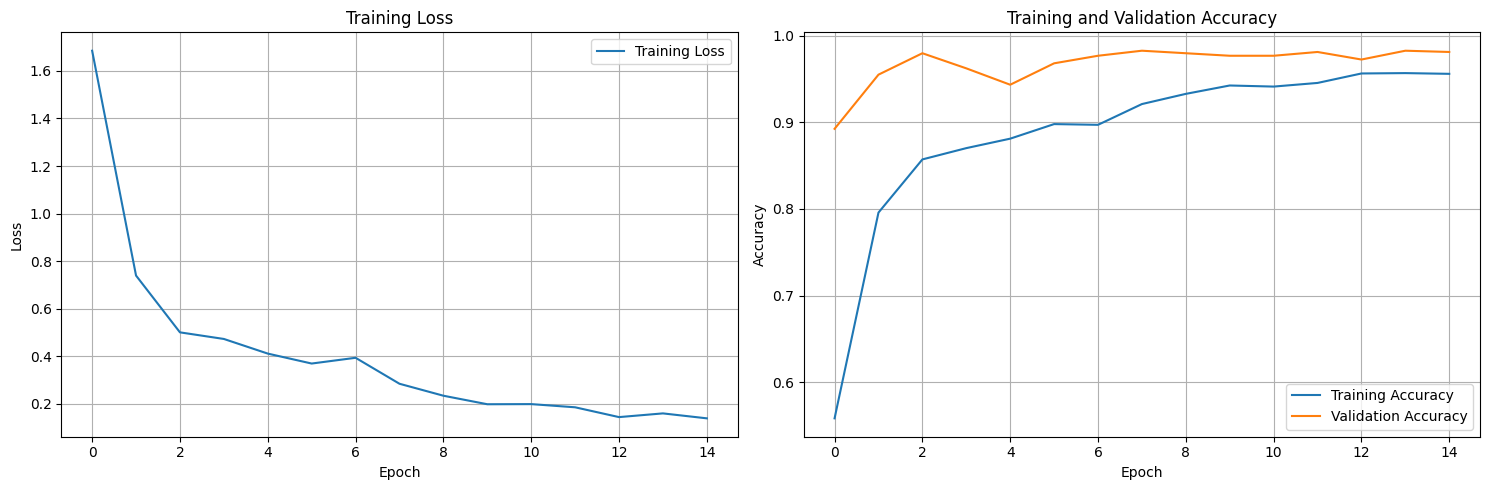

📊 Training history plot saved as 'training_history.png'

🔍 Evaluating model...


C:\Users\vedan\AppData\Local\Temp\ipykernel_27548\878998462.py:183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.devic

FileNotFoundError: [Errno 2] No such file or directory: 'b3_model.pth'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import time
import random

class EfficientNetB3ISLClassifier:
    def __init__(self, data_dir, num_classes=None, device=None):
        self.data_dir = data_dir
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Transforms (adjusted for EfficientNet-B3 size)
        self.train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(300),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        self.val_transforms = transforms.Compose([
            transforms.Resize(320),
            transforms.CenterCrop(300),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Setup data
        self.setup_datasets()
        self.model = self.create_model()
        self.best_acc = 0.0
        self.class_names = self.train_dataset.classes
        
        print(f"✅ EfficientNet-B3 initialized")
        print(f"📱 Device: {self.device}")
        print(f"🎯 Number of classes: {len(self.class_names)}")
        print(f"📊 Training samples: {len(self.train_dataset)}")
        print(f"📊 Validation samples: {len(self.val_dataset)}")
    
    def setup_datasets(self):
        self.train_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, "train"), transform=self.train_transforms)
        
        self.val_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, "valid"), transform=self.val_transforms)
        
        test_path = os.path.join(self.data_dir, "test")
        if os.path.exists(test_path):
            self.test_dataset = datasets.ImageFolder(test_path, transform=self.val_transforms)
        else:
            self.test_dataset = None
        
        self.train_loader = DataLoader(self.train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
        if self.test_dataset:
            self.test_loader = DataLoader(self.test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

    def create_model(self):
        model = models.efficientnet_b3(pretrained=True)
        num_classes = len(self.train_dataset.classes)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
        return model.to(self.device)

    def train(self, num_epochs=15, learning_rate=0.001, save_path="best_efficientnet_b3_model.pth"):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        train_losses = []
        train_accuracies = []
        val_accuracies = []

        print(f"🚀 Starting training for {num_epochs} epochs...")
        print("=" * 60)

        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()
            train_running_loss = 0.0
            train_running_corrects = 0

            train_pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
            for inputs, labels in train_pbar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                train_running_corrects += torch.sum(preds == labels.data)

                train_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{train_running_corrects.double() / len(self.train_dataset):.4f}'
                })

            epoch_loss = train_running_loss / len(self.train_dataset)
            epoch_acc = train_running_corrects.double() / len(self.train_dataset)
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())

            self.model.eval()
            val_running_corrects = 0
            with torch.no_grad():
                val_pbar = tqdm(self.val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
                for inputs, labels in val_pbar:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    _, preds = torch.max(outputs, 1)
                    val_running_corrects += torch.sum(preds == labels.data)
                    val_pbar.set_postfix({
                        'Acc': f'{val_running_corrects.double() / len(self.val_dataset):.4f}'
                    })

            val_acc = val_running_corrects.double() / len(self.val_dataset)
            val_accuracies.append(val_acc.item())
            scheduler.step()

            print(f"Epoch {epoch+1}/{num_epochs} - Time: {time.time() - start_time:.2f}s")
            print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}")

            if val_acc > self.best_acc:
                self.best_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_acc': self.best_acc,
                    'class_names': self.class_names
                }, save_path)
                print(f"✅ New best model saved! Accuracy: {val_acc:.4f}")
            print("-" * 60)

        print(f"🎯 Training completed! Best validation accuracy: {self.best_acc:.4f}")
        self.plot_training_history(train_losses, train_accuracies, val_accuracies)

        return {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
            'best_acc': self.best_acc.item()
        }

    def plot_training_history(self, train_losses, train_accuracies, val_accuracies):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(train_losses, label='Training Loss')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(train_accuracies, label='Training Accuracy')
        ax2.plot(val_accuracies, label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("📊 Training history plot saved as 'training_history.png'")

    def load_model(self, model_path):
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.best_acc = checkpoint['best_acc']
        self.class_names = checkpoint['class_names']
        print(f"✅ Model loaded from {model_path}")
        print(f"📊 Best accuracy: {self.best_acc:.4f}")

    def test_on_image(self, image_path, model_path=None):
        if model_path:
            self.load_model(model_path)

        image = Image.open(image_path).convert('RGB')
        input_tensor = self.val_transforms(image)
        input_batch = input_tensor.unsqueeze(0).to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(input_batch)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

        top_probs, top_indices = torch.topk(probabilities, 5)
        top_probs = top_probs.cpu().numpy()
        top_indices = top_indices.cpu().numpy()

        print(f"\n🔍 Testing image: {image_path}")
        print("="*50)
        for i in range(len(top_probs)):
            class_name = self.class_names[top_indices[i]]
            confidence = top_probs[i] * 100
            print(f"#{i+1}: {class_name} - {confidence:.2f}%")

        return {
            'predictions': [(self.class_names[idx], prob) for idx, prob in zip(top_indices, top_probs)],
            'top_class': self.class_names[top_indices[0]],
            'confidence': top_probs[0]
        }

    def evaluate_model(self, model_path=None, use_test_set=False):
        if model_path:
            self.load_model(model_path)

        if use_test_set and self.test_dataset:
            eval_loader = self.test_loader
            eval_dataset = self.test_dataset
            set_name = "Test"
        else:
            eval_loader = self.val_loader
            eval_dataset = self.val_dataset
            set_name = "Validation"

        print(f"🔍 Evaluating model on {set_name} set...")
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(eval_loader, desc="Evaluating"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
        print(f"\n📊 {set_name} Set Accuracy: {accuracy:.4f}")
        print("\n📋 Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=self.class_names))

        self.plot_confusion_matrix(all_labels, all_preds)
        return {'accuracy': accuracy, 'predictions': all_preds, 'labels': all_labels}

    def plot_confusion_matrix(self, labels, predictions):
        cm = confusion_matrix(labels, predictions)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("📊 Confusion matrix saved as 'confusion_matrix.png'")


def main():
    data_dir = r"E:\New folder\isl_inverted"
    classifier = EfficientNetB3ISLClassifier(data_dir)

    print("🚀 Starting training...")
    classifier.train(num_epochs=15, learning_rate=0.001, save_path="best_efficientnet_b3_model.pth")

    print("\n🔍 Evaluating model...")
    classifier.evaluate_model("b3_model.pth")

    print("\n🖼️ Testing on sample images...")
    val_samples = []
    for class_idx, class_name in enumerate(classifier.class_names):
        class_path = os.path.join(data_dir, "valid", class_name)
        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if images:
                val_samples.append(os.path.join(class_path, random.choice(images)))

    for i, image_path in enumerate(val_samples[:3]):
        print(f"\n--- Sample {i+1} ---")
        result = classifier.test_on_image(image_path, "best_efficientnet_b3_model.pth")
        print(f"Predicted: {result['top_class']} ({result['confidence']*100:.2f}%)")


if __name__ == "__main__":
    print("📦 Required packages:")
    print("pip install torch torchvision matplotlib seaborn scikit-learn tqdm pillow")
    print("\n" + "=" * 60)
    main()
